In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer 

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score
from sklearn.feature_selection import SelectKBest, f_classif

In [3]:
train = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv')
test= pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv')
greeks = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/greeks.csv')


## **SOME SIMPLE EXPLORATORY DATA ANALYSIS**

In [4]:
train

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,...,0.173229,1.26092,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000,0
613,fd895603f071,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,...,10.223150,1.24236,0.426699,35.896418,496.994214,3085.308063,29.648928,124.808872,0.145340,0
614,fd8ef6377f76,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,...,0.173229,0.49706,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000,0
615,fe1942975e40,0.363205,1263.53524,85.200147,23.685856,8.138688,7.981959,0.025578,7.524588,1.229900,...,9.256996,0.78764,0.670527,24.594488,72.611063,1965.343176,25.116750,37.155112,0.184622,0


### Target distribution: 'Class'

In [66]:
train['Class'].value_counts()/617

0    0.824959
1    0.175041
Name: Class, dtype: float64

82% $\longrightarrow$ class 0 \
18% $\longrightarrow$ class 1

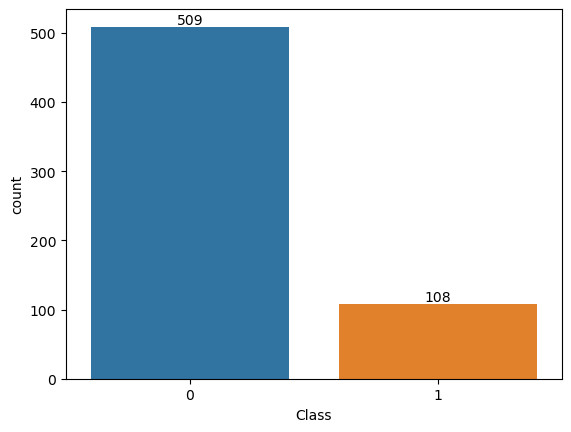

In [69]:
sns.countplot(x=train['Class'])

for p in plt.gca().patches:
    count = int(p.get_height())
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    plt.gca().annotate(count, (x, y), ha='center', va='bottom')

# Display the plot
plt.show()

We have imbalanced classes that probably need to be handled later. The negative class is around 4.71 times larger than the positive one.

### Missing values:

In [58]:
missing_df=train.isnull().sum().to_frame(name='missing_values')
missing_df[missing_df['missing_values']!=0].transpose()

,BQ,CB,CC,DU,EL,FC,FL,FS,GL
missing_values,60,2,3,1,60,1,1,2,1


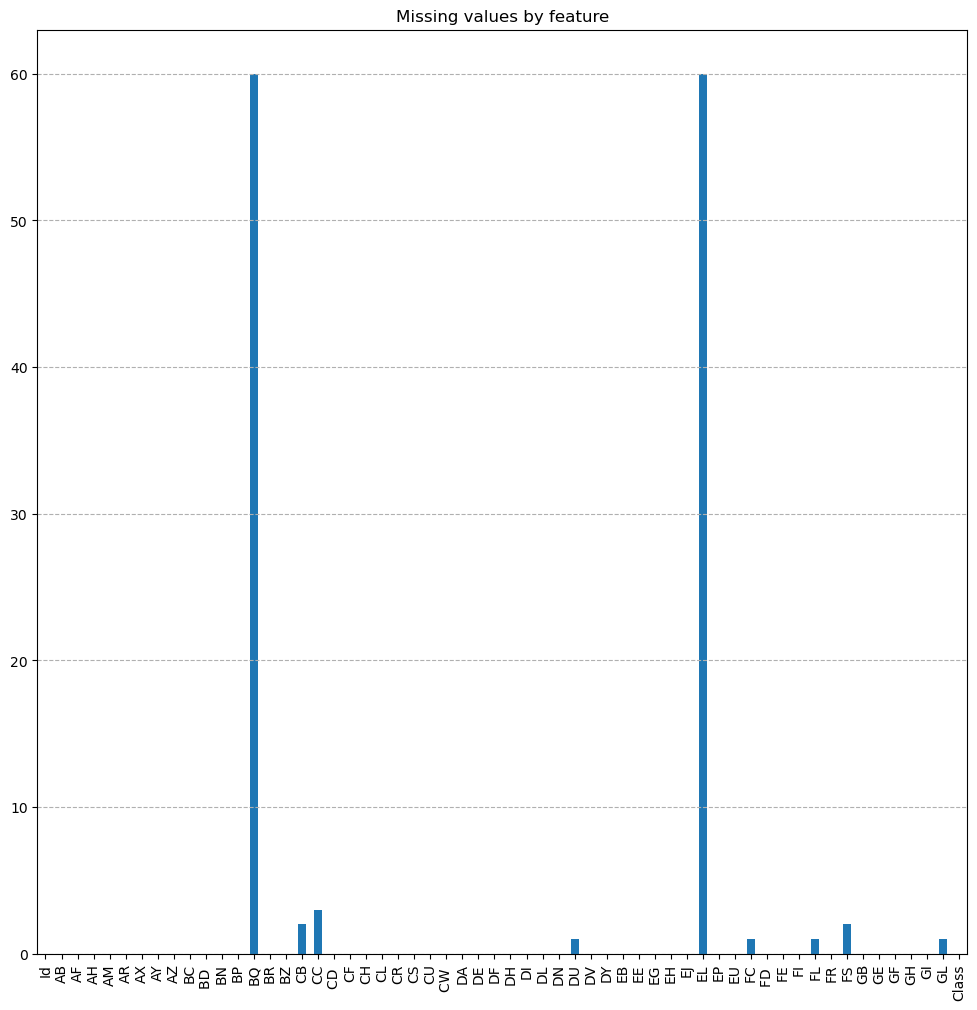

In [19]:
train.isnull().sum().plot.bar(figsize=(12,12))
plt.title('Missing values by feature')
plt.grid(axis='y',linestyle='--')
plt.show()

9 features contain missing values. Only 'BQ' and 'EL' features have a significant amount of NAN.

### Some other general info on main train dataset

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      615 non-null    float64
 17  CC      614 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

All features but 'EJ' are numeric.

In [5]:
train.describe()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
count,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,...,616.000000,617.000000,615.000000,617.000000,617.000000,617.000000,617.000000,617.000000,616.000000,617.000000
mean,0.477149,3502.013221,118.624513,38.968552,10.128242,5.545576,0.060320,10.566447,8.053012,5350.388655,...,5.433199,3.533905,0.421501,20.724856,131.714987,14679.595398,31.489716,50.584437,8.530961,0.175041
std,0.468388,2300.322717,127.838950,69.728226,10.518877,2.551696,0.416817,4.350645,65.166943,3021.326641,...,11.496257,50.181948,1.305365,9.991907,144.181524,19352.959387,9.864239,36.266251,10.327010,0.380310
min,0.081187,192.593280,85.200147,3.177522,8.138688,0.699861,0.025578,3.396778,1.229900,1693.624320,...,0.173229,0.497060,0.067730,4.102182,72.611063,13.038894,9.432735,0.897628,0.001129,0.000000
25%,0.252107,2197.345480,85.200147,12.270314,8.138688,4.128294,0.025578,8.129580,1.229900,4155.702870,...,0.173229,0.497060,0.067730,14.036718,72.611063,2798.992584,25.034888,23.011684,0.124392,0.000000
50%,0.354659,3120.318960,85.200147,20.533110,8.138688,5.031912,0.025578,10.461320,1.229900,4997.960730,...,3.028141,1.131000,0.250601,18.771436,72.611063,7838.273610,30.608946,41.007968,0.337827,0.000000
75%,0.559763,4361.637390,113.739540,39.139886,8.138688,6.431634,0.036845,12.969516,5.081244,6035.885700,...,6.238814,1.512060,0.535067,25.608406,127.591671,19035.709240,36.863947,67.931664,21.978000,0.000000
max,6.161666,28688.187660,1910.123198,630.518230,178.943634,38.270880,10.315851,38.971568,1463.693448,53060.599240,...,137.932739,1244.227020,31.365763,135.781294,1497.351958,143790.071200,81.210825,191.194764,21.978000,1.000000


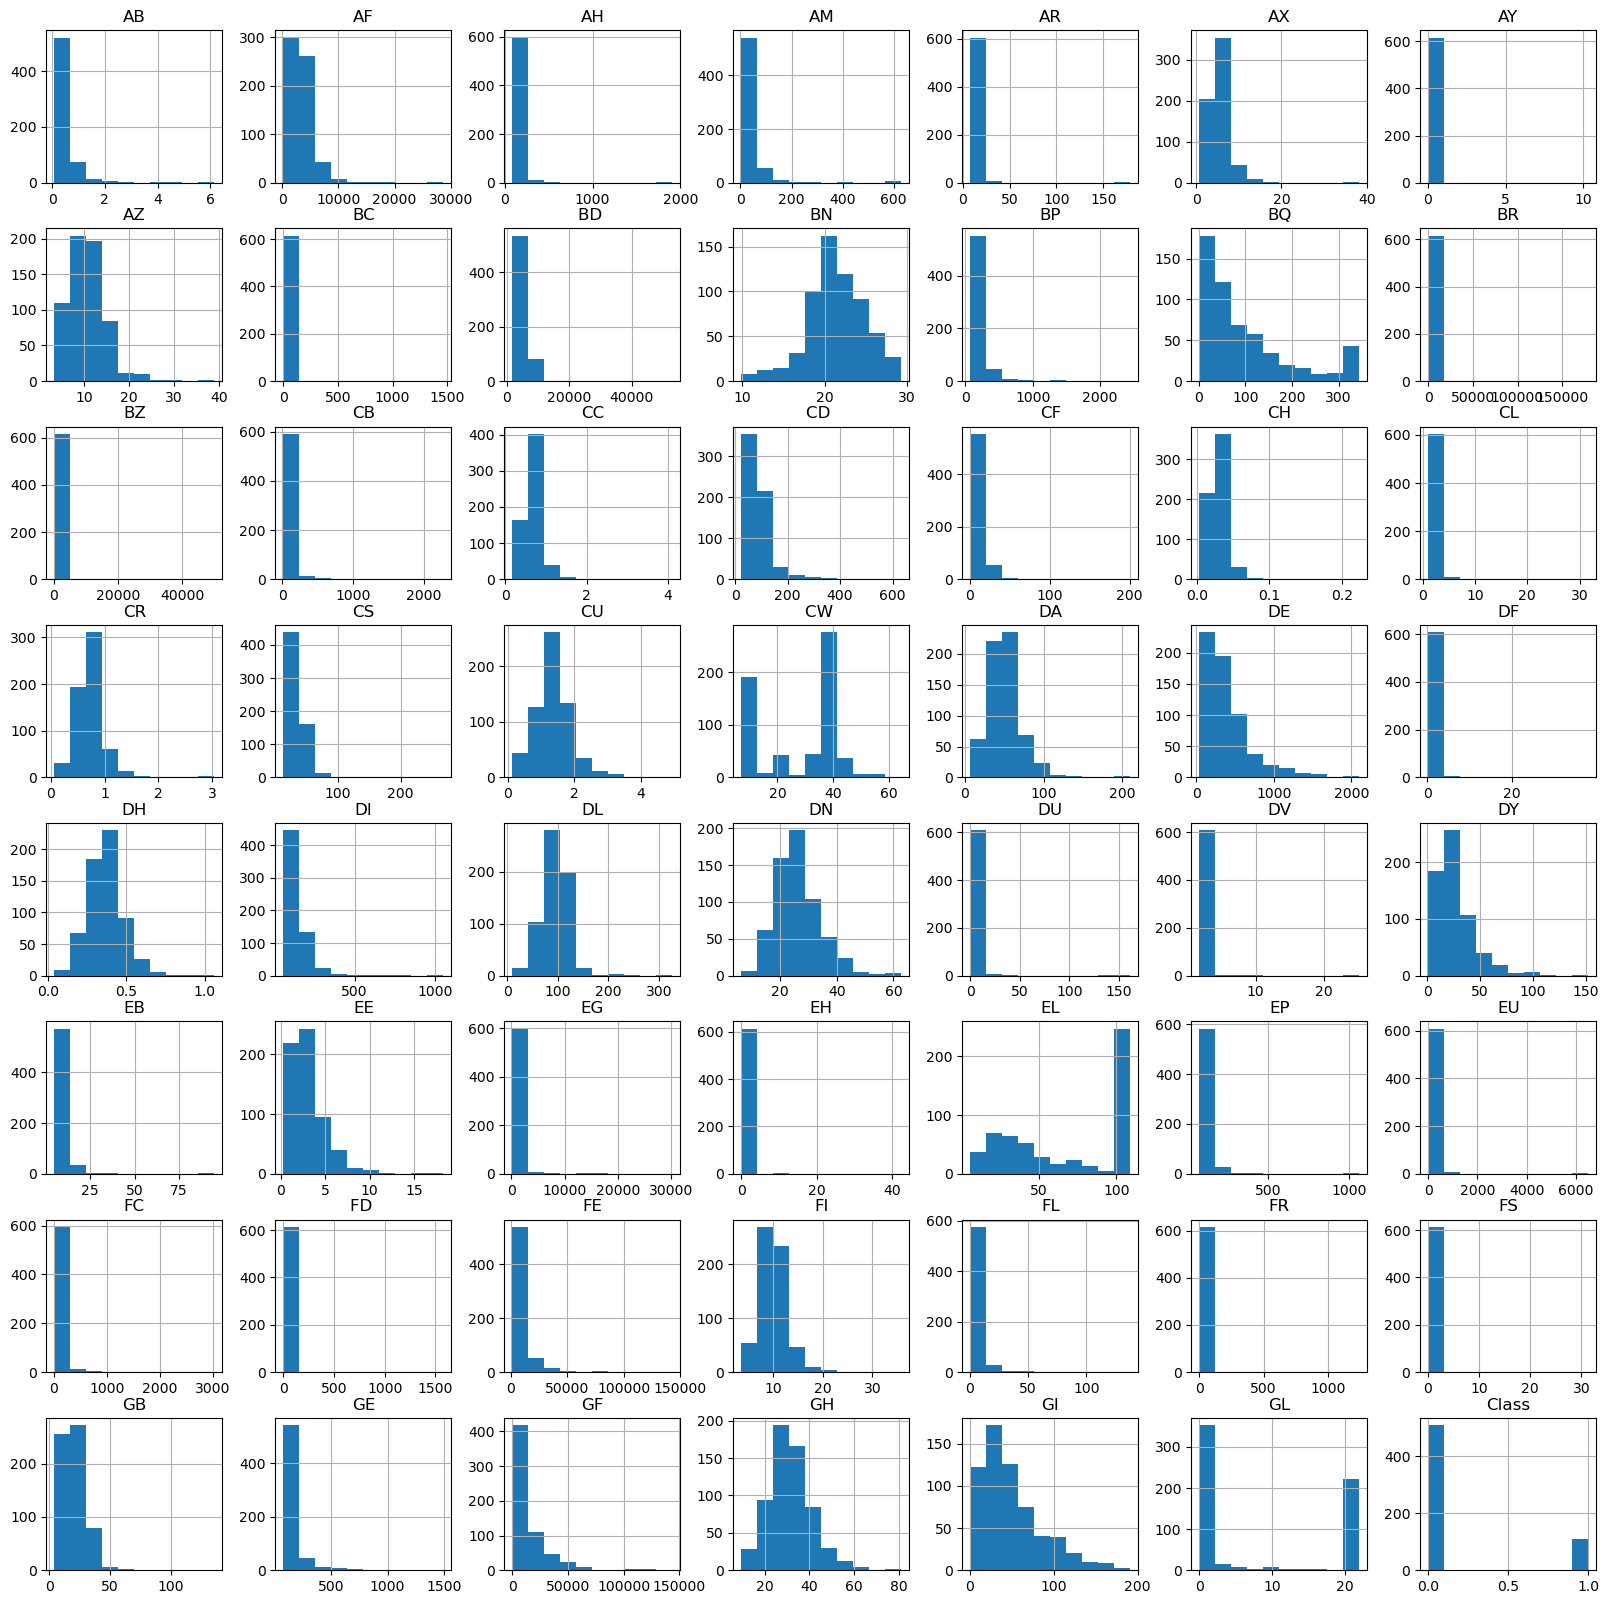

In [63]:
# Numerical Features distribution

train.hist(figsize=(20,20))
plt.show()

There seems to be outliers that we will need to take care of, eventually. 

[Text(0.5, 1.0, "'EJ' feature distribution")]

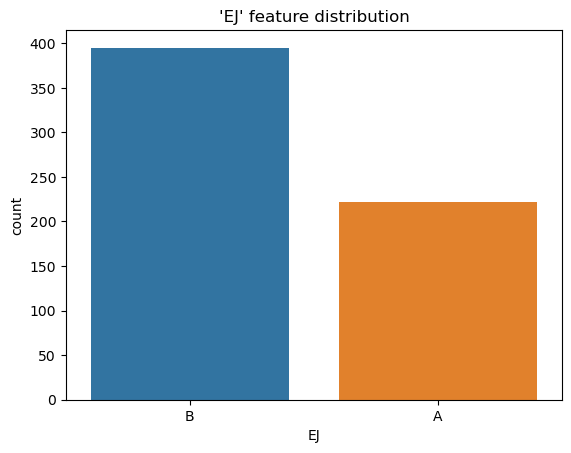

In [70]:
# Categorical feature EJ distribution:

sns.countplot(x=train['EJ']).set(title="'EJ' feature distribution")


'EJ' contains 2 categories: 'A' and 'B'.

## **DATA PREPARATION**

In [71]:
# define features and target

ID = train['Id']
X_train = train.drop(['Id','Class'],axis=1)
y_train = train['Class']

In [45]:
# set 'Id' as index
X_train.index=ID
X_train

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
Id,,,,,,,,,,,,,,,,,,,,,
000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343
007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000
013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941
043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829
044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,...,9.879296,0.173229,1.26092,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000
fd895603f071,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,5654.07556,...,10.910227,10.223150,1.24236,0.426699,35.896418,496.994214,3085.308063,29.648928,124.808872,0.145340
fd8ef6377f76,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,5888.87769,...,12.029366,0.173229,0.49706,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000


In [46]:
y_train.index=ID
y_train

Id
000ff2bfdfe9    1
007255e47698    0
013f2bd269f5    0
043ac50845d5    0
044fb8a146ec    1
               ..
fd3dafe738fd    0
fd895603f071    0
fd8ef6377f76    0
fe1942975e40    0
ffcca4ded3bb    0
Name: Class, Length: 617, dtype: int64

In [47]:
# extract numerical and categorical feature names in lists.

num_features = list(X_train.select_dtypes(include=['float']))
cat_features = ['EJ']


We create a pipeline for numeric features that : 
1. imputes missing values with the median. 
2. Standardizes features

In [48]:
# we create a pipeline for numeric features that : 1. imputes missing values with the median. 2.Standardizes data.

num_pipeline = Pipeline([
                        ("median", SimpleImputer(strategy='median'))#,
                        #("std_scaler", StandardScaler())
                        ])

In [49]:
# column transformer that applies the num pipeline and one ohe encodes 'EJ'

full_pipeline = ColumnTransformer([("num", num_pipeline, num_features),          # lista de tuplas donde cada tupla contiene ("nombre cualq", Transformador, lista de columnas a aplicar el transformador)
                                   ("cat", OneHotEncoder(), cat_features)
                                  ])

In [50]:
X_train_prepared=full_pipeline.fit_transform(X_train)

In [51]:
# get the trasnformed features names
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_features = cat_encoder.categories_
cat_feature_names = [f"{feature}_{category}"
                     for feature, categories in zip(cat_features, cat_one_hot_features)
                     for category in categories]

all_feature_names = num_features + cat_feature_names

In [52]:
# put it back as adataframe

X_train_prepared_df = pd.DataFrame(X_train_prepared, columns=all_feature_names, index= ID)
X_train_prepared_df

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FR,FS,GB,GE,GF,GH,GI,GL,EJ_A,EJ_B
Id,,,,,,,,,,,,,,,,,,,,,
000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,0.0,1.0
007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,1.0,0.0
013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0.0,1.0
043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0.0,1.0
044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,...,1.26092,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000,1.0,0.0
fd895603f071,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,5654.07556,...,1.24236,0.426699,35.896418,496.994214,3085.308063,29.648928,124.808872,0.145340,0.0,1.0
fd8ef6377f76,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,5888.87769,...,0.49706,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000,1.0,0.0


In [53]:
# Adjust some datatypes
for col in ['EJ_A','EJ_B']:
    X_train_prepared_df[col] = X_train_prepared_df[col].astype(int)
    
X_train_prepared_df.dtypes

AB      float64
AF      float64
AH      float64
AM      float64
AR      float64
AX      float64
AY      float64
AZ      float64
BC      float64
BD      float64
BN      float64
BP      float64
BQ      float64
BR      float64
BZ      float64
CB      float64
CC      float64
CD      float64
CF      float64
CH      float64
CL      float64
CR      float64
CS      float64
CU      float64
CW      float64
DA      float64
DE      float64
DF      float64
DH      float64
DI      float64
DL      float64
DN      float64
DU      float64
DV      float64
DY      float64
EB      float64
EE      float64
EG      float64
EH      float64
EL      float64
EP      float64
EU      float64
FC      float64
FD      float64
FE      float64
FI      float64
FL      float64
FR      float64
FS      float64
GB      float64
GE      float64
GF      float64
GH      float64
GI      float64
GL      float64
EJ_A      int64
EJ_B      int64
dtype: object

In [34]:
#from skagglearn.model_selection import train_test_split

#X_train_1, X_valid, y_train_1, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## **Modeling** 

- Handling Imbalanced data

In [54]:
y_train.value_counts()

0    509
1    108
Name: Class, dtype: int64

In [55]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
rus = RandomUnderSampler(sampling_strategy=0.5)

X_under, y_under = rus.fit_resample(X_train_prepared_df, y_train)

print(Counter(y_under))

Counter({0: 216, 1: 108})


In [66]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE(sampling_strategy=0.7)
X_over, y_over = oversample.fit_resample(X_under, y_under)

print(Counter(y_over))

Counter({0: 216, 1: 151})


In [56]:
# evaluation metric 
from sklearn.metrics import log_loss
def balanced_log_loss(y_true, y_pred, class_weights):
    weights = np.array([class_weights[int(label)] for label in y_true])
    loss = log_loss(y_true, y_pred, sample_weight=weights)
    return loss

- Fit a LightGBM model

In [67]:
#import xgboost as xgb
#from catboost import CatBoostClassifier
#from sklearn.ensemble import VotingClassifier
import lightgbm as lgb

#xgb_clf = xgb.XGBClassifier(n_estimators=50, scale_pos_weight=4.71) 
#cat_clf = CatBoostClassifier(num_boost_round=50)
lgb_clf = lgb.LGBMClassifier(num_boost_round=50, objective='binary' , scale_pos_weight=4 , learning_rate=0.1, metric="binary_logloss" ,max_bin=125)
#voting_clf = VotingClassifier(
  #estimators=[ ('lgb', lgb_clf),('catboost', cat_clf), ('xgb', xgb_clf)],
  #voting='soft') 
#voting_clf.fit(X_train, y_train)
lgb_clf.fit(X_over,y_over)
y_train_pred = cross_val_predict(lgb_clf,X_over,y_over,cv=10,method="predict_proba")
    
w_0= 367/216
w_1= 367/151
class_weights = {0: w_0, 1: w_1}

balanced_loss = balanced_log_loss(y_over, y_train_pred, class_weights)
print("Balanced Log Loss:", balanced_loss)

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
Balanced Log Loss: 0.20470483456629499


### Hyperparameter tuning

In [68]:
from sklearn.metrics import  make_scorer
from sklearn.model_selection import GridSearchCV


scorer = make_scorer(balanced_log_loss, greater_is_better=False, needs_proba=True, class_weights=class_weights)

param_grid = [{'objective' : ['binary'],
                   'is_unbalance': ['True'],
                   'num_boost_round' : [40, 45, 50, 55, 60],
                   'booster': ['gbdt', 'rf'],
                   'max_bin' : [125,255]},
                
                  {'objective' : ['binary'],
                   'is_unbalance': ['False'],
                   'scale_pos_weight': [3.5, 4, 4.5],
                   'num_boost_round' : [40, 45, 50, 55, 60],
                   'booster': ['gbdt', 'rf'],
                   'max_bin' : [125,255]}
                  ]

grid_search_lgb = GridSearchCV(lgb_clf,                           #  estimador del modelo
                           param_grid,                           #  param_grid : lista de diccionarios con las combinaciones deseadas
                           cv=10,                                 #  N° de folds para cross validation
                           scoring=scorer,                   #  scoring (debe ser funcion de utilidad)
                           return_train_score=True)

In [69]:
grid_search_lgb.fit(X_over,y_over)

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[LightGBM] [Fatal] Cannot set is_unbalance and scale_pos_weight at the same time
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[LightGBM] [Fatal] Cannot set is_unbalance and scale_pos_weight at the same time
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[LightGBM] [Fatal] Cannot set is_unbalance and scale_pos_weight at the same time
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boo

[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


[LightGBM] [Fatal] Cannot set is_unbalance and scale_pos_weight at the same time
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[LightGBM] [Fatal] Cannot set is_unbalance and scale_pos_weight at the same time
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[LightGBM] [Fatal] Cannot set is_unbalance and scale_pos_weight at the same time
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[LightGBM] [Fatal] Cannot set is_unbalance and scale_pos_weight at the same time
/opt/conda

[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=45, num_boost_round=45 will be ignored. Current value: num_iterations=45
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py", line 967, in fit
    super().fit(X, _y, sample_weight=sample_weight, init_score=init_score, eval_set=valid_sets,
  File "/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py", line 748, in fit
    self._Booster = train(
  File "/opt/con

[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


GridSearchCV(cv=10,
             estimator=LGBMClassifier(max_bin=125, metric='binary_logloss',
                                      num_boost_round=50, objective='binary',
                                      scale_pos_weight=4),
             param_grid=[{'booster': ['gbdt', 'rf'], 'is_unbalance': ['True'],
                          'max_bin': [125, 255],
                          'num_boost_round': [40, 45, 50, 55, 60],
                          'objective': ['binary']},
                         {'booster': ['gbdt', 'rf'], 'is_unbalance': ['False'],
                          'max_bin': [125, 255],
                          'num_boost_round': [40, 45, 50, 55, 60],
                          'objective': ['binary'],
                          'scale_pos_weight': [3.5, 4, 4.5]}],
             return_train_score=True,
             scoring=make_scorer(balanced_log_loss, greater_is_better=False, needs_proba=True, class_weights={0: 1.6990740740740742, 1: 2.4304635761589406}))

In [72]:
final_lgb = grid_search_lgb.best_estimator_


In [ ]:
#w_0= 124/101
#w_1= 124/23
#class_weights = {0: w_0, 1: w_1}

#balanced_loss = balanced_log_loss(y_valid, y_valid_pred, class_weights)
#print("Balanced Log Loss:", balanced_loss)

### Predictions on test data:

In [120]:
#test['Class']=1
test

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,02fa521e1838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,040e15f562a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,046e85c7cc7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [121]:
X_test = test.drop(['Id'],axis=1)

In [122]:
ID = test['Id']
X_test.index=ID
X_test

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
Id,,,,,,,,,,,,,,,,,,,,,
00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02fa521e1838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
040e15f562a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
046e85c7cc7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [127]:
test_prepared = full_pipeline.transform(X_test)

In [128]:
test_prepared_df = pd.DataFrame(test_prepared, columns=all_feature_names, index=ID)

test_prepared_df

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FR,FS,GB,GE,GF,GH,GI,GL,EJ_A,EJ_B
Id,,,,,,,,,,,,,,,,,,,,,
00eed32682bb,-1.019531,-1.523636,-0.928674,-0.559317,-0.963645,-2.175054,-0.144832,-2.430678,-0.123675,-1.772311,...,-0.070479,-0.323252,-2.075847,-0.914277,-0.759135,-3.194901,-1.395939,-0.825715,1.0,0.0
010ebe33f668,-1.019531,-1.523636,-0.928674,-0.559317,-0.963645,-2.175054,-0.144832,-2.430678,-0.123675,-1.772311,...,-0.070479,-0.323252,-2.075847,-0.914277,-0.759135,-3.194901,-1.395939,-0.825715,1.0,0.0
02fa521e1838,-1.019531,-1.523636,-0.928674,-0.559317,-0.963645,-2.175054,-0.144832,-2.430678,-0.123675,-1.772311,...,-0.070479,-0.323252,-2.075847,-0.914277,-0.759135,-3.194901,-1.395939,-0.825715,1.0,0.0
040e15f562a2,-1.019531,-1.523636,-0.928674,-0.559317,-0.963645,-2.175054,-0.144832,-2.430678,-0.123675,-1.772311,...,-0.070479,-0.323252,-2.075847,-0.914277,-0.759135,-3.194901,-1.395939,-0.825715,1.0,0.0
046e85c7cc7f,-1.019531,-1.523636,-0.928674,-0.559317,-0.963645,-2.175054,-0.144832,-2.430678,-0.123675,-1.772311,...,-0.070479,-0.323252,-2.075847,-0.914277,-0.759135,-3.194901,-1.395939,-0.825715,1.0,0.0


In [129]:


for col in ['EJ_A','EJ_B']:
    test_prepared_df[col] = test_prepared_df[col].astype(int)
    
test_prepared_df

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FR,FS,GB,GE,GF,GH,GI,GL,EJ_A,EJ_B
Id,,,,,,,,,,,,,,,,,,,,,
00eed32682bb,-1.019531,-1.523636,-0.928674,-0.559317,-0.963645,-2.175054,-0.144832,-2.430678,-0.123675,-1.772311,...,-0.070479,-0.323252,-2.075847,-0.914277,-0.759135,-3.194901,-1.395939,-0.825715,1,0
010ebe33f668,-1.019531,-1.523636,-0.928674,-0.559317,-0.963645,-2.175054,-0.144832,-2.430678,-0.123675,-1.772311,...,-0.070479,-0.323252,-2.075847,-0.914277,-0.759135,-3.194901,-1.395939,-0.825715,1,0
02fa521e1838,-1.019531,-1.523636,-0.928674,-0.559317,-0.963645,-2.175054,-0.144832,-2.430678,-0.123675,-1.772311,...,-0.070479,-0.323252,-2.075847,-0.914277,-0.759135,-3.194901,-1.395939,-0.825715,1,0
040e15f562a2,-1.019531,-1.523636,-0.928674,-0.559317,-0.963645,-2.175054,-0.144832,-2.430678,-0.123675,-1.772311,...,-0.070479,-0.323252,-2.075847,-0.914277,-0.759135,-3.194901,-1.395939,-0.825715,1,0
046e85c7cc7f,-1.019531,-1.523636,-0.928674,-0.559317,-0.963645,-2.175054,-0.144832,-2.430678,-0.123675,-1.772311,...,-0.070479,-0.323252,-2.075847,-0.914277,-0.759135,-3.194901,-1.395939,-0.825715,1,0


In [131]:
# get the probabilities for each class
proba_predictions = final_lgb.predict_proba(test_prepared_df)
proba_predictions

array([[0.72946702, 0.27053298],
       [0.72946702, 0.27053298],
       [0.72946702, 0.27053298],
       [0.72946702, 0.27053298],
       [0.72946702, 0.27053298]])

In [132]:
header = ['class_0','class_1']
Id=test_prepared_df.index

In [133]:
proba_predictions_df = pd.DataFrame(proba_predictions, index=Id, columns=header)
proba_predictions_df

,class_0,class_1
Id,,
00eed32682bb,0.729467,0.270533
010ebe33f668,0.729467,0.270533
02fa521e1838,0.729467,0.270533
040e15f562a2,0.729467,0.270533
046e85c7cc7f,0.729467,0.270533


In [134]:
# save the predictions in a csv file as we were asked for.
proba_predictions_df.to_csv('submission.csv')